# Gaussian linear regression - standalone


In [1]:
%pip install --upgrade pip
# freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip freeze

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
for i, dev in enumerate(jax.devices()):
  print(f"Device {i}. {dev}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Device 0. TFRT_CPU_0


In [4]:
import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
from welford import *
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

sigsq_t = tfb.Exp()

def generate(key: jax.random.KeyArray, N: int, beta0: jax.Array, sigsq0: jax.Array):
    y_key, X_key = jax.random.split(key)
    p = len(beta0)
    X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
    y = X@beta0 + jnp.sqrt(sigsq0)*tfd.Normal(loc=0, scale=1.).sample(sample_shape=(N,), seed=y_key)
    return y, X

def to_constrained(theta: Theta) -> Theta:
    return Theta(beta=theta.beta, sigsq=sigsq_t.forward(theta.sigsq))

def get_model(y, X, K):
    N, p = X.shape
    # use exp to transform sigsq to unconstrained space

    beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
    sigsq_prior = tfd.InverseGamma(2.0, 2.0)

    def logjoint_density(theta: Theta, fold_id: int, model_id: int, prior_only: bool = False) -> jax.Array:
        """Log joint density for a given fold.
        
        Args:
            theta: model parameters
            fold_id: zero-based fold id for training set, -1 for entire dataset
            model_id: 0 for model A, 1 for model B
            prior_only: if True, only return prior density
        
        Returns:
            log density
        """
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
        # prior is same for all folds
        lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
        ll_mask = ((jnp.arange(N) % K) != fold_id).astype(jnp.float32)  # select fold
        # model A has all the predictors, model B is missing the last predictor
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        eps = (y - X @ (theta.beta * beta_mask))
        ll_contribs = tfd.Normal(loc=0., scale=jnp.sqrt(sigsq)).log_prob(eps)
        ll = (ll_mask * ll_contribs).sum() * (not prior_only)
        return lp + ll + sigsq_ldj

    # predictive density log p(y_train|theta)
    def log_pred(theta: Theta, fold_id: int, model_id: int):
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        pred_mask = ((jnp.arange(N) % K) == fold_id).astype(jnp.float32)
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
        return (pred_mask * ll_contribs).sum()

    # random initialization in the constrained parameter space
    def make_initial_pos(key: jax.random.KeyArray):
        k1, k2 = jax.random.split(key)
        theta = Theta(
            beta=jax.random.normal(key=k1, shape=(p,)),
            sigsq=jax.random.normal(key=k2))
        return theta

    return logjoint_density, log_pred, make_initial_pos


In [7]:
num_folds=5
num_models=2
num_chains=16
batch_size=150
num_integration_steps=10

total_batches=500
warmup_iter=1_000

random_seed=123
inference_key, data_key=jax.random.split(jax.random.PRNGKey(random_seed))

y, X = generate(key=data_key,
                N = 100,
                beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
                sigsq0 = jnp.array(2.0))
logjoint_density, log_pred, make_initial_pos = get_model(y, X, num_folds)

In [8]:
@jax.jit
def find_initial_params(rng_key, fold_id, model_id):
    """Use adam to approximately maximize the log joint density."""""
    import optax
    params = make_initial_pos(rng_key)
    optimizer = optax.adam(learning_rate=1.0)
    f = lambda x: -logjoint_density(x, fold_id, model_id, prior_only=False)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, _ = jax.lax.fori_loop(0, 100, loop_body, (params, state))
    return params


Window adaptation to find a good step size, inverse mass matrix for full-data model

In [9]:
class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: LogWelfordState  # accumulator for log predictive
    pred_bws: BatchLogWelfordState  # batch accumulator for log predictive, size b
    pred_bws3: BatchLogWelfordState  # batch accumulator for log predictive, size floor(b/3)
    divergences: jax.Array  # divergence counts (int array)

def init_ext_state(state, rng_key):
    """Create initial state"""
    return ExtendedState(
        state=state,
        rng_key=rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

def reset_ext_state(state):
    """Reset averages after warmup"""
    return ExtendedState(
        state=state.state,
        rng_key=state.rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

from functools import partial
@partial(jax.jit, static_argnames=['num_samples', 'is_online'])
def inference_loop(ext_states, fold_id, model_id, num_samples, is_online) -> Tuple[ExtendedState, HMCState]:
    hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    def one_chain_inference_loop(state):  # Single chain inference loop
        def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
            # Single chain, single MCMC step.
            iter_key, carry_key = jax.random.split(ext_state.rng_key)
            chain_state, chain_info = hmc.step(iter_key, ext_state.state)
            elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
            carry_state = ExtendedState(
                state=chain_state,
                rng_key=carry_key,
                pred_ws=log_welford_add(elpd_contrib, ext_state.pred_ws),
                pred_bws=batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                pred_bws3=batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                divergences=ext_state.divergences + chain_info.is_divergent,
            )
            if is_online:
                return carry_state, None  # don't retain chain trace
            else:
                return carry_state, chain_state.position
        next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
        return next_state, trace
    # run all chains for this fold in parallel
    return jax.vmap(one_chain_inference_loop)(ext_states)


Initialize inference

In [11]:
def sense_check_init_pos(fm_init_pos):
    # sense check initial positions generate reasonable log likelihoods
    print("log joint density sense checks")
    m0ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 0)
    m1ljd = jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, -1, 1)
    print(f"ljd mean m0: {jnp.mean(m0ljd):.2f} m1: {jnp.mean(m1ljd):.2f} diff (m0 - m1): {jnp.mean(m1ljd - m0ljd):.2f}")
    for m in range(num_models):
        print()
        fljds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"ljd m{m} folds: {', '.join([f'{f:.2f}' for f in fljds])}")
        flprds = jnp.array([
            jax.vmap(logjoint_density, in_axes=(0, None, None, None))(fm_init_pos, f, m, True).mean()
            for f in range(num_folds)])
        print(f"lpriord m{m} folds: {', '.join([f'{f:.2f}' for f in flprds])}")
        flpds = jnp.array([
            jax.vmap(log_pred, in_axes=(0, None, None))(fm_init_pos, f, m).mean()
            for f in range(num_folds)])
        print(f"lpredd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds])}")
        print(f"lpredd+ljd m{m} folds: {', '.join([f'{f:.2f}' for f in flpds+fljds])}")

## Single fold test



### Offline inference (full data)


In [12]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

state, trace = inference_loop(state, fold_id, model_id, batch_size*total_batches, False)
assert jnp.all(state.divergences < 5), f"{state.divergences.sum()} divergences during inference"

# transform back to constrained parameter space
constrained_trace = jax.vmap(to_constrained)(trace)
import arviz as az
idata = az.convert_to_inference_data({v : constrained_trace[i] for i, v in enumerate(trace._fields)})

Running window adaptation



Step size = 0.6925, inv mm norm = 0.0769

log joint density sense checks
ljd mean m0: -200.50 m1: -204.00 diff (m0 - m1): -3.50

ljd m0 folds: -163.02, -166.44, -159.75, -165.60, -161.36
lpriord m0 folds: -14.16, -14.16, -14.16, -14.16, -14.16
lpredd m0 folds: -37.49, -34.06, -40.75, -34.90, -39.14
lpredd+ljd m0 folds: -200.50, -200.50, -200.50, -200.50, -200.50

ljd m1 folds: -165.08, -168.91, -163.26, -168.21, -164.69
lpriord m1 folds: -14.16, -14.16, -14.16, -14.16, -14.16
lpredd m1 folds: -38.92, -35.09, -40.73, -35.79, -39.30
lpredd+ljd m1 folds: -204.00, -204.00, -204.00, -204.00, -204.00


In [13]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.068,0.216,0.661,1.474,0.001,0.001,61040.0,168893.0,1.0
beta[1],1.019,0.195,0.655,1.388,0.001,0.000,88717.0,219330.0,1.0
beta[2],1.097,0.186,0.746,1.445,0.001,0.000,72493.0,208404.0,1.0
beta[3],0.398,0.187,0.048,0.752,0.000,0.000,147722.0,330344.0,1.0
sigsq,2.745,0.447,1.949,3.577,0.004,0.003,15257.0,22609.0,1.0


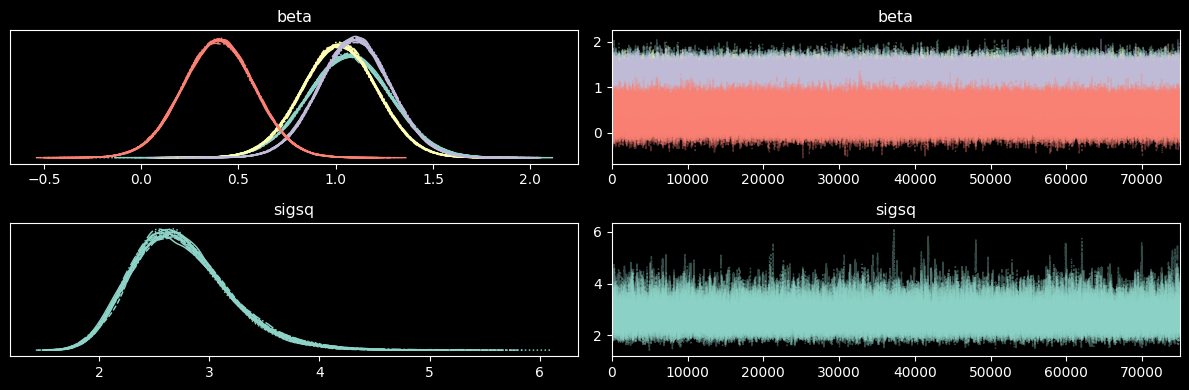

In [14]:
az.plot_trace(idata, var_names=['beta', 'sigsq'])
plt.tight_layout()

### Batched online inference (full data)

In [33]:
state_k, sampling_k = jax.random.split(inference_key)

fold_id, model_id = 1, 0

# parameter adaptation
init_pos_1c = find_initial_params(state_k, fold_id, model_id)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

sense_check_init_pos(fm_init_pos)

# burn-in
state, _ = inference_loop(initstate, fold_id, model_id, warmup_iter, False)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in

means = []
for i in range(total_batches):
    state, _ = inference_loop(state, fold_id, model_id, batch_size, True)
    pmean = logsumexp(log_welford_mean(state.pred_ws)) - jnp.log(num_chains)
    means.append(pmean)
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
means = jnp.stack(means)

Running window adaptation



Step size = 0.6925, inv mm norm = 0.0769

log joint density sense checks
ljd mean m0: -200.50 m1: -204.00 diff (m0 - m1): -3.50

ljd m0 folds: -163.02, -166.44, -159.75, -165.60, -161.36
lpriord m0 folds: -14.16, -14.16, -14.16, -14.16, -14.16
lpredd m0 folds: -37.49, -34.06, -40.75, -34.90, -39.14
lpredd+ljd m0 folds: -200.50, -200.50, -200.50, -200.50, -200.50

ljd m1 folds: -165.08, -168.91, -163.26, -168.21, -164.69
lpriord m1 folds: -14.16, -14.16, -14.16, -14.16, -14.16
lpredd m1 folds: -38.92, -35.09, -40.73, -35.79, -39.30
lpredd+ljd m1 folds: -204.00, -204.00, -204.00, -204.00, -204.00


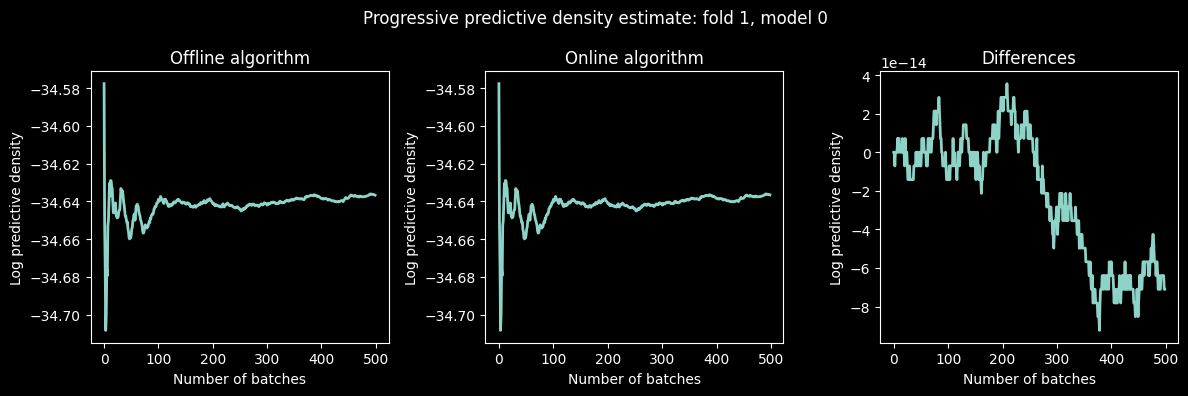

In [50]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
offline, online, diffs = axes

offline.plot(means, linewidth=2)
offline.set_title('Offline algorithm')

lp_draws = jax.vmap(jax.vmap(lambda x: log_pred(x, fold_id, model_id)))(trace)
from scipy.special import logsumexp
lps = [logsumexp(lp_draws[:, :m]) - jnp.log(num_chains * m)
       for m in range(batch_size, batch_size*total_batches, batch_size)]
lps = jnp.array(lps)
online.plot(lps, linewidth=2)
online.set_title('Online algorithm')

diffs.plot(means[:-1] - lps, linewidth=2)
diffs.set_title('Differences')

for ax in axes:
    ax.set_xlabel("Number of batches")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive predictive density estimate: fold {fold_id}, model {model_id}')
fig.tight_layout()
fig.savefig('online_vs_offline.pdf', bbox_inches=0, transparent=True)

## Online cross-validation

In [82]:
state_k, sampling_k = jax.random.split(inference_key)

# parameter adaptation - just model 0 and full data
init_pos_1c = find_initial_params(state_k, -1, 0)
adapt = bj.window_adaptation(bj.hmc, lambda x: logjoint_density(x, fold_id, model_id),
                             num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), init_pos_1c, num_steps=2_000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")
print()

models, folds = jnp.arange(num_models), jnp.arange(num_folds)

def init_one_fold(fold_id, model_id):
    fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    state_ks = jax.random.split(state_k, num_chains)
    fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
    fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
    return jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

# dimensions models x folds x chains x param dimension
init_state = jax.vmap(lambda model_id: jax.vmap(init_one_fold, in_axes=(0, None))(folds, model_id))(models)
def model_inference_loop(state, model_id, iter):
    return jax.vmap(lambda state, fold_id: inference_loop(state, fold_id, model_id, iter, True))(state, folds)
grand_inference_loop = jax.vmap(model_inference_loop, in_axes=(0, 0, None))

# burn-in
#state, _ = grand_inference_loop(init_state, models, warmup_iter)
#state = jax.vmap(jax.vmap(jax.vmap(reset_ext_state)))(state)  # discard values accumulated during burn-in
state = init_state

means = []
for i in range(total_batches):
    state, _ = grand_inference_loop(state, models, batch_size)
    pmean = logsumexp(log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
    means.append(pmean)
assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
means = jnp.stack(means)
model_means = means.sum(axis=2)
delta = model_means[:, 0] - model_means[:, 1]

Running window adaptation



Step size = 0.7170, inv mm norm = 0.0762



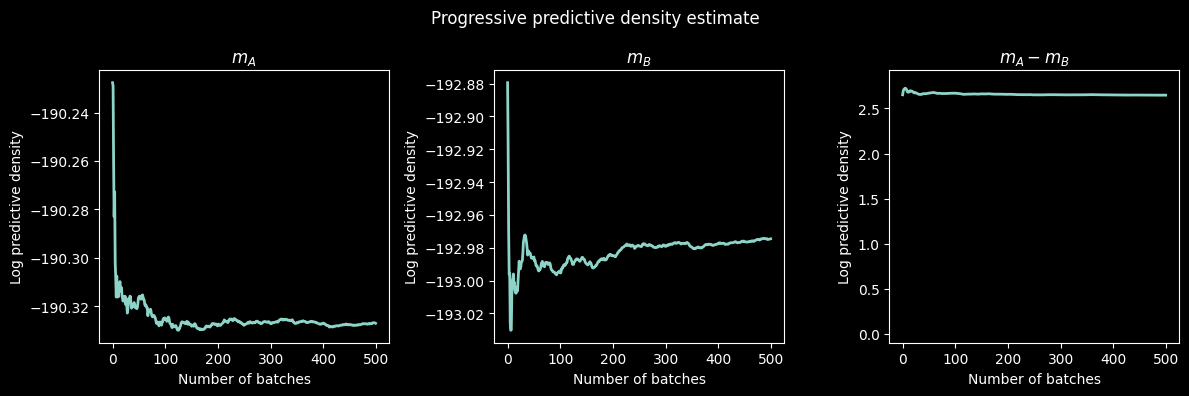

In [85]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
mA, mB, diffs = axes

mA.plot(model_means[:,0], linewidth=2)
mA.get_yaxis().get_major_formatter().set_useOffset(False)
mA.set_title('$m_A$')
mB.plot(model_means[:,1], linewidth=2)
mB.get_yaxis().get_major_formatter().set_useOffset(False)
mB.set_title('$m_B$')
diffs.plot(delta, linewidth=2)
diffs.set_title('$m_A - m_B$')
diffs.set_ylim(-0.1, delta.mean()*1.1)

for ax in axes:
    ax.set_xlabel("Number of batches")
    ax.set_ylabel("Log predictive density")

fig.suptitle(f'Progressive predictive density estimate')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)